## Model QSAR generation

This part of the code was generated previously https://github.com/RollerCoaster1899/Quantitative_Structure-Activity_Relationship/blob/main/Quantitative_Structure%E2%80%93Activity_Relationship.ipynb

In [1]:
import numpy as np
from chembl_webresource_client.new_client import new_client
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, PandasTools, rdMolDescriptors
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [2]:
def target_retrieval(search):
    target = new_client.target
    target_query = target.search(search)
    targets = pd.DataFrame.from_dict(target_query)

    return targets

def target_info_retrieval(search):
    target = search['target_chembl_id'].iloc[0]
    activity = new_client.activity
    res = activity.filter(target_chembl_id=target, standard_type="IC50")
    df_1 = pd.DataFrame.from_dict(res)

    return df_1, target

def build_qsar_model(data):
    # Step 2: Clean the data
    df = pd.DataFrame(data)

    if 'value' not in df.columns:
        print('No data available for the given target and assay type.')
        return None

    # Remove rows with missing values
    df.dropna(subset=['value'], inplace=True)

    if df.empty:
        print('No data available for the given target and assay type after cleaning.')
        return None

    # Step 3: Calculate pIC50
    df['value'] = pd.to_numeric(df['value'], errors='coerce')
    df['pIC50'] = -np.log10(df['value'] * 1e-9)

    # Step 4: Calculate molecular fingerprints
    mols = [Chem.MolFromSmiles(smiles) for smiles in df['canonical_smiles']]
    fingerprints = [rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, 2) for mol in mols]
    fingerprint_array = np.array(fingerprints)
    df_fingerprints = pd.DataFrame(fingerprint_array, columns=[f'Bit_{i}' for i in range(fingerprint_array.shape[1])])

    # Step 5: Construct a QSAR model
    X = df_fingerprints
    y = df['pIC50']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    return model, X_test, y_test, df_fingerprints.columns

def evaluate_molecule(mol_smiles, model):
    if model is None:
        print('Model not available. Please build the QSAR model first.')
        return None

    mol = Chem.MolFromSmiles(mol_smiles)
    fingerprint = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, 2)
    X = pd.DataFrame([list(fingerprint)], columns=[f'Bit_{i}' for i in range(fingerprint.GetNumBits())])
    pIC50 = model.predict(X)
    return pIC50[0]

def plot_predicted_vs_real(y_test, y_pred):
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    plt.xlabel('Real pIC50')
    plt.ylabel('Predicted pIC50')
    plt.title('Predicted vs. Real pIC50')
    plt.show()

def identify_pharmacophores(feature_importance, fingerprint_columns, threshold=0.01):
    pharmacophores = []
    for i, importance in enumerate(feature_importance):
        if importance > threshold:
            pharmacophores.append(fingerprint_columns[i])
    return pharmacophores

def draw_molecule(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        Chem.SanitizeMol(mol)
        return Chem.Draw.MolToImage(mol)
    else:
        return None

In [3]:
# Example usage
search_term = "CHEMBL2179"
df_targets = target_retrieval(search_term)
df_activity, target_id = target_info_retrieval(df_targets)

In [4]:
# Print target information and activity data
print("Target Information:")
print(df_targets)
print("\nActivity Data:")
print(df_activity)

Target Information:
                                    cross_references      organism   
0  [{'xref_id': 'P04062', 'xref_name': None, 'xre...  Homo sapiens  \
1                                                 []  Homo sapiens   

                      pref_name  score  species_group_flag target_chembl_id   
0       Beta-glucocerebrosidase   14.0               False       CHEMBL2179  \
1  Glucocerebrosidase GBA1/GBA2   12.0               False    CHEMBL4106172   

                                   target_components     target_type  tax_id  
0  [{'accession': 'P04062', 'component_descriptio...  SINGLE PROTEIN    9606  
1  [{'accession': 'P04062', 'component_descriptio...  PROTEIN FAMILY    9606  

Activity Data:
                                           action_type activity_comment   
0                                                 None             None  \
1                                                 None             None   
2                                                 Non

In [5]:
model, X_test, y_test, fingerprint_columns = build_qsar_model(df_activity)

In [6]:
# Example molecule evaluation
test_mol_smiles = 'CC(=O)NC1=CC=CC=C1'
pIC50 = evaluate_molecule(test_mol_smiles, model)
if pIC50 is not None:
    print(f'Predicted pIC50: {pIC50}')

Predicted pIC50: 7.8932730757333465


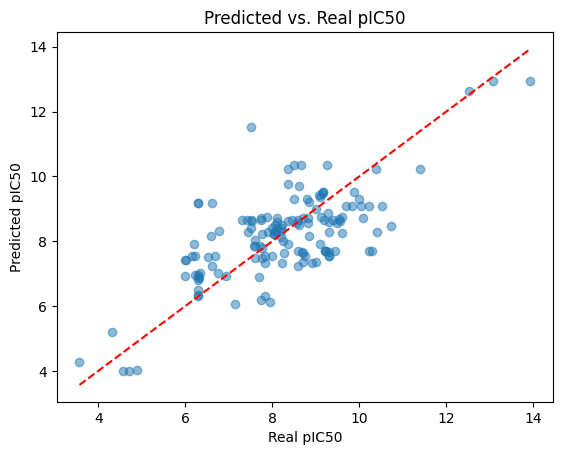

In [7]:
# Generate plots
y_pred = model.predict(X_test)
plot_predicted_vs_real(y_test, y_pred)

## Virtual Screening

In [8]:
import pandas as pd
from rdkit import Chem, DataStructs
from chembl_webresource_client.new_client import new_client
from rdkit.Chem import PandasTools
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_molecule(mol_smiles, model):
    if model is None:
        print('Model not available. Please build the QSAR model first.')
        return None

    mol = Chem.MolFromSmiles(mol_smiles)
    fingerprint = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, 2)
    X = pd.DataFrame([list(fingerprint)], columns=[f'Bit_{i}' for i in range(fingerprint.GetNumBits())])
    pIC50 = model.predict(X)
    return pIC50[0]

# Load the data from CSV
df = pd.read_csv('QSAR-Virtual_Screening_Data.csv')  # Replace 'world.csv' with the actual CSV file path

# Example molecule evaluation
df['pIC50'] = df['smiles'].apply(lambda x: evaluate_molecule(x, model))

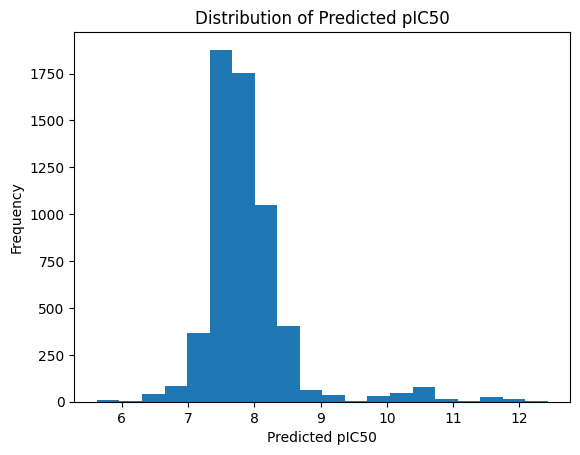

In [9]:
# Sort the DataFrame based on 'pIC50' column in descending order
df_sorted = df.sort_values(by='pIC50', ascending=False)

# Select the top 10 molecules with the highest potency values
top_10 = df_sorted.head(10)

# Generate potency distribution plot
plt.hist(df['pIC50'], bins=20)
plt.xlabel('Predicted pIC50')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted pIC50')
plt.show()

Molecule 1603 - SMILES: NC[C@@H]1CC[C@@H](N)[C@@H](O[C@@H]2[C@@H](N)C[C@@H](N)[C@H](O[C@H]3O[C@H](CO)[C@@H](O)[C@H](N)[C@H]3O)[C@H]2O)O1, Predicted pIC50: 12.42768525575477


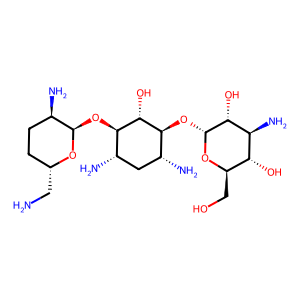

Molecule 2910 - SMILES: NC[C@H]1O[C@H](O[C@@H]2[C@@H](N)C[C@@H](N)[C@H](O[C@H]3O[C@H](CO)[C@@H](O)[C@H](N)[C@H]3O)[C@H]2O)[C@H](O)[C@@H](O)[C@@H]1O, Predicted pIC50: 12.395453539749099


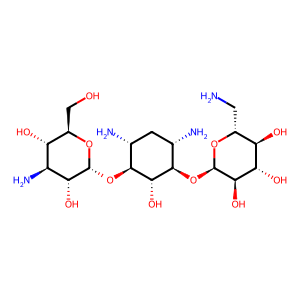

Molecule 1922 - SMILES: C#Cc1cccc(Nc2ncnc3cc4c(cc23)OCCOCCOCCO4)c1, Predicted pIC50: 12.164077288788281


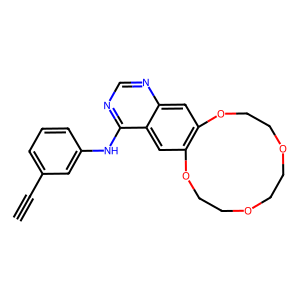

Molecule 930 - SMILES: CC(C)=NNc1nncc2ccccc12, Predicted pIC50: 12.0616345446555


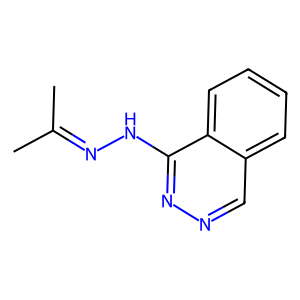

Molecule 5229 - SMILES: COc1ccc(OC)c([C@H](O)[C@@H](C)N)c1, Predicted pIC50: 11.970644044544494


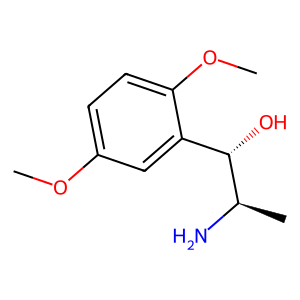

Molecule 3724 - SMILES: COc1ccc(OC)c([C@@H](O)[C@H](C)N)c1, Predicted pIC50: 11.970644044544494


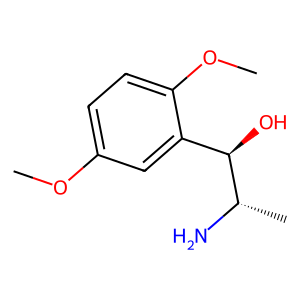

Molecule 1592 - SMILES: COc1ccc(OC)c([C@H](O)[C@H](C)N)c1, Predicted pIC50: 11.970644044544494


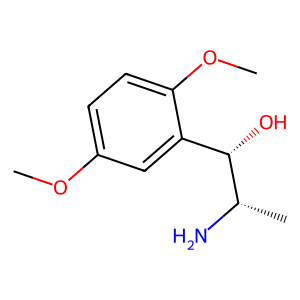

Molecule 5239 - SMILES: COc1ccc(OC)c([C@@H](O)[C@@H](C)N)c1, Predicted pIC50: 11.970644044544494


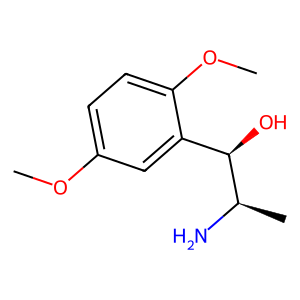

Molecule 888 - SMILES: NCC[C@H](O)C(=O)N[C@@H]1C[C@H](N)[C@@H](O[C@H]2O[C@H](CN)CC[C@H]2N)[C@H](O)[C@H]1O[C@H]1O[C@H](CO)[C@@H](O)[C@H](N)[C@H]1O, Predicted pIC50: 11.953128932422958


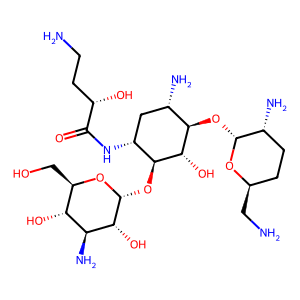

Molecule 1019 - SMILES: CC1=C(CC(=O)O)c2cc(F)ccc2/C1=C/c1ccc(S(C)(=O)=O)cc1, Predicted pIC50: 11.928751699211768


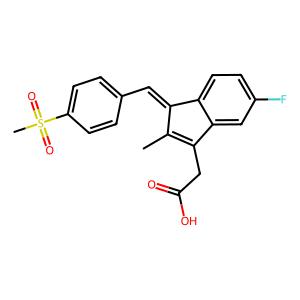

In [10]:
# Generate images and print molecule information for the top 10
for i, row in top_10.iterrows():
    image = draw_molecule(row['smiles'])
    if image is not None:
        print(f"Molecule {i + 1} - SMILES: {row['smiles']}, Predicted pIC50: {row['pIC50']}")
        display(image)

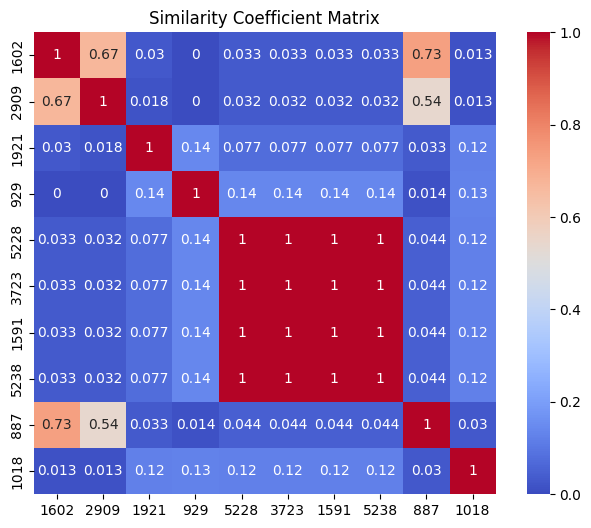

In [11]:
# Generate a matrix of similarity coefficients between the top 10 molecules
similarity_matrix = []
for i in range(len(top_10)):
    sim_row = []
    for j in range(len(top_10)):
        mol_i = Chem.MolFromSmiles(top_10.iloc[i]['smiles'])
        mol_j = Chem.MolFromSmiles(top_10.iloc[j]['smiles'])
        fp_i = rdMolDescriptors.GetMorganFingerprint(mol_i, 2)
        fp_j = rdMolDescriptors.GetMorganFingerprint(mol_j, 2)
        similarity = DataStructs.TanimotoSimilarity(fp_i, fp_j)
        sim_row.append(similarity)
    similarity_matrix.append(sim_row)

# Convert the similarity matrix to a DataFrame for better visualization
similarity_df = pd.DataFrame(similarity_matrix, columns=top_10.index, index=top_10.index)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(similarity_df, cmap='coolwarm', annot=True, square=True)
plt.title('Similarity Coefficient Matrix')
plt.show()